In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

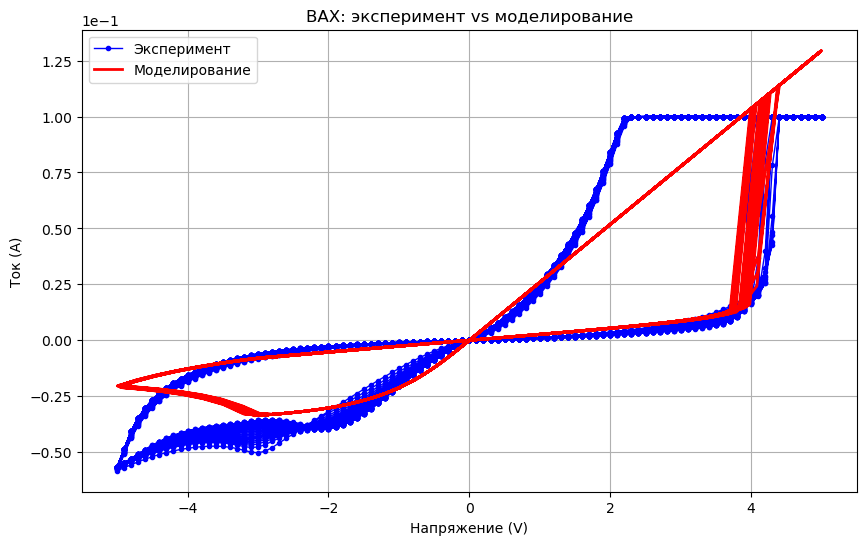

In [ ]:
# Чтение исходных данных
df_exp = pd.read_csv('data/LiNbO3.csv', sep='\t')  
df_exp.columns = ['t', 'v', 'c']

# Чтение результатов моделирования
df_sim = pd.read_csv('memristor_results.csv', sep=',')  
df_sim.columns = ['t', 'V', 'I']

# График ВАХ
plt.figure(figsize=(10, 6))
plt.plot(df_exp['v'], df_exp['c'], 'bo-', linewidth=1, markersize=3, label='Эксперимент')
plt.plot(df_sim['V'], df_sim['I'], 'r-', linewidth=2, label='Моделирование')
plt.xlabel('Напряжение (V)')
plt.ylabel('Ток (A)')
plt.title('ВАХ: эксперимент vs моделирование')
plt.grid(True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()
plt.show()

# Реализация на Python

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from typing import List, Tuple

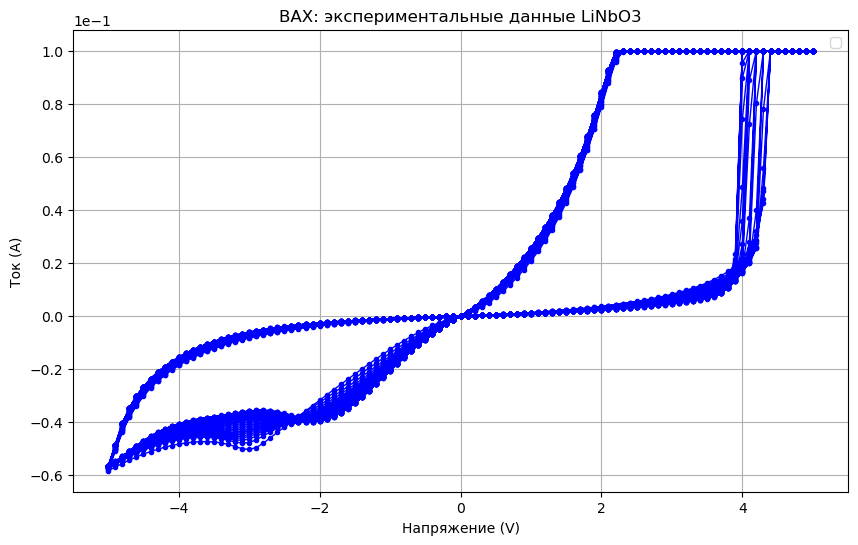

In [19]:
df_exp = pd.read_csv('data/LiNbO3.csv', sep='\t')  
df_exp.columns = ['t', 'v', 'c']

plt.figure(figsize=(10, 6))
plt.plot(df_exp['v'], df_exp['c'], 'bo-', linewidth=1, markersize=3,)
plt.xlabel('Напряжение (V)')
plt.ylabel('Ток (A)')
plt.title('ВАХ: экспериментальные данные LiNbO3')
plt.grid(True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()
plt.show()

### Реализация модели мемристора

In [46]:
class LinearInterpolator:
    """Класс для линейной интерполяции, работающий с массивами"""
    def __init__(self, x_data: np.ndarray, y_data: np.ndarray):
        self.x_data = np.array(x_data)
        self.y_data = np.array(y_data)
    
    def __call__(self, x: float | np.ndarray) -> float | np.ndarray:
        """Перегрузка оператора () для работы с массивами"""
        # Если x - массив, обрабатываем каждый элемент
        if isinstance(x, np.ndarray):
            return np.array([self._interpolate_single(xi) for xi in x])
        else:
            return self._interpolate_single(x)
    
    def _interpolate_single(self, x: float) -> float:
        """Интерполяция для одного значения"""
        # Если x за пределами данных, возвращаем граничные значения
        if x <= self.x_data[0]:
            return self.y_data[0]
        if x >= self.x_data[-1]:
            return self.y_data[-1]
        
        # Находим индекс для интерполяции (бинарный поиск)
        idx = np.searchsorted(self.x_data, x)
        
        if idx == 0:
            return self.y_data[0]
        
        x0 = self.x_data[idx - 1]
        x1 = self.x_data[idx]
        y0 = self.y_data[idx - 1]
        y1 = self.y_data[idx]
        
        # Линейная интерполяция
        return y0 + (y1 - y0) * (x - x0) / (x1 - x0)

In [143]:
class MemristorModel:
    def __init__(self, df: pd.DataFrame, steps: int = 5000):
        """
        df : pd.DataFrame
            DataFrame с колонками ['t', 'v', 'c']
        steps : int
            Количество шагов для сетки
        """
        # Извлекаем данные из DataFrame
        self.t_exp = df['t'].values.astype(float)
        self.V_exp = df['v'].values.astype(float)
        self.I_exp = df['c'].values.astype(float)
        
        self.steps = steps
        self.V_func = LinearInterpolator(self.t_exp, self.V_exp)
        self.I_func = LinearInterpolator(self.t_exp, self.I_exp)
        
        # Временные параметры
        t0, t_end = self.t_exp[0], self.t_exp[-1]
        self.dt = (t_end - t0) / steps
        
        # Создаем сетки (используем numpy вместо циклов)
        self.t_grid = np.linspace(t0, t_end, steps + 1)
        self.V_grid = self.V_func(self.t_grid)
        self.I_grid = self.I_func(self.t_grid)
        
        # # Параметры модели
        # self.params = np.array([
        #     49.6,       # Ron (Ом)
        #     2170.81,    # Roff (Ом)
        #     1853.54,    # mu_v
        #     0.1143,     # Vp (В)
        #     -2.55,      # Vn (В)
        #     290.384,    # D (нм)
        #     0.78        # x0
        # ])

                # Параметры модели
        self.params = np.array([
            205,       # Ron (Ом)
            2130,    # Roff (Ом)
            0.0006,    # mu_v
            0.65,     # Vp (В)
            -0.87,      # Vn (В)
            620,    # D (нм)
            0.1        # x0
        ])
    
    def I_model(self, x: float, V: float, params: np.ndarray = None) -> float:
        """Ток через мемристор"""
        if params is None:
            params = self.params
        
        Ron, Roff = params[0], params[1]
        R_mem = Ron * x + Roff * (1 - x)
        return V / R_mem if R_mem != 0 else 0
    
    def dxdt(self, x: float, V: float, params: np.ndarray = None) -> float:
        """Производная состояния мемристора"""
        if params is None:
            params = self.params
        
        I_mem = self.I_model(x, V, params)
        Ron, mu_v, Vp, Vn, D = params[0], params[2], params[3], params[4], params[5]
        
        if V >= Vp:
            exponent = Ron * I_mem / Vp
            return (mu_v * Vp / (D * D)) * np.exp(np.clip(exponent, -100, 100))
        elif V <= Vn:
            exponent = Ron * I_mem / Vn
            return (mu_v * Vn / (D * D)) * np.exp(np.clip(exponent, -100, 100))
        else:
            return mu_v * Ron * I_mem / (D * D)
    
    def solve_x(self, params: np.ndarray = None) -> np.ndarray:
        """Метод Рунге-Кутта 4 порядка (векторизованный)"""
        if params is None:
            params = self.params
        
        x_sol = np.zeros(self.steps + 1)
        x_sol[0] = params[6]
        
        for i in range(self.steps):
            t = self.t_grid[i]
            V = self.V_grid[i]
            x = x_sol[i]
            
            k1 = self.dt * self.dxdt(x, V, params)
            k2 = self.dt * self.dxdt(x + k1/2, V, params)
            k3 = self.dt * self.dxdt(x + k2/2, V, params)
            k4 = self.dt * self.dxdt(x + k3, V, params)
            
            x_sol[i+1] = x + (k1 + 2*k2 + 2*k3 + k4) / 6
            x_sol[i+1] = np.clip(x_sol[i+1], 0, 1)
        
        return x_sol
    
    def get_I_solution(self, params: np.ndarray = None) -> np.ndarray:
        """Получение решения для тока"""
        if params is None:
            params = self.params
        
        x_sol = self.solve_x(params)
        
        # Векторизованный расчет тока
        R_mem = params[0] * x_sol + params[1] * (1 - x_sol)
        I_sol = self.V_grid / np.where(R_mem != 0, R_mem, 1e-12)
        
        return I_sol
    
    def objective_function(self, params: np.ndarray = None) -> float:
        """Целевая функция (MSE)"""
        if params is None:
            params = self.params
        
        I_sol = self.get_I_solution(params)
        
        return np.mean((I_sol - self.I_grid) ** 2)

In [144]:
param_names = ['Ron', 'Roff', 'mu_v', 'Vp', 'Vn', 'D', 'x0']

def print_params(params, title=None):
    if title:
        print(f"\n{title}")
        print("-" * len(title))
    for name, val in zip(param_names, params):
        print(f"{name:>5s} = {val:12.6g}")


In [145]:
model = MemristorModel(df_exp, steps=5000)
initial_error = model.objective_function()
print(f"\nНачальная ошибка модели: {initial_error:.2e}")


Начальная ошибка модели: 2.34e-03


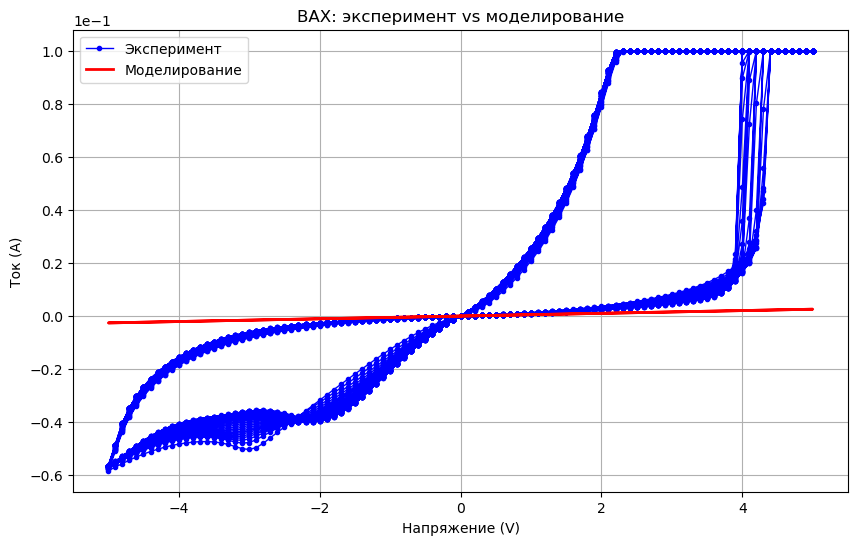

In [146]:
# График ВАХ
plt.figure(figsize=(10, 6))
plt.plot(df_exp['v'], df_exp['c'], 'bo-', linewidth=1, markersize=3, label='Эксперимент')
plt.plot(model.V_grid, model.get_I_solution(), 'r-', linewidth=2, label='Моделирование')
plt.xlabel('Напряжение (V)')
plt.ylabel('Ток (A)')
plt.title('ВАХ: эксперимент vs моделирование')
plt.grid(True)
plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.legend()
plt.show()

In [147]:
print_params(model.params)

  Ron =          205
 Roff =         2130
 mu_v =       0.0006
   Vp =         0.65
   Vn =        -0.87
    D =          620
   x0 =          0.1


### Оптимизация

In [148]:
from scipy.optimize import minimize
# Границы параметров:
# [Ron, Roff, mu_v, Vp, Vn, D, x0]
bounds = np.array([
    [10, 100],        # Ron
    [1500, 3000],      # Roff
    [1000, 10000],       # mu_v
    [0.05, 1.0],      # Vp
    [-3.0, -0.05],    # Vn
    [50, 1000],       # D
    [0.0, 1.0],       # x0
])

def objective_wrapper(params):
    return model.objective_function(params)

In [149]:
def random_search(n_samples=300):
    results = []

    for i in range(n_samples):
        params = np.array([
            np.random.uniform(low, high)
            for low, high in bounds
        ])

        try:
            err = objective_wrapper(params)
            results.append((err, params))
        except Exception:
            continue

        if i % 20 == 0:
            print(f"{i}/{n_samples}")

    results.sort(key=lambda x: x[0])
    return results

results = random_search(n_samples=1000)


0/1000
20/1000
40/1000
60/1000
80/1000
100/1000
120/1000
140/1000
160/1000
180/1000
200/1000
220/1000
240/1000
260/1000
280/1000
300/1000
320/1000
340/1000
360/1000
380/1000
400/1000
420/1000
440/1000
460/1000
480/1000
500/1000
520/1000
540/1000
560/1000
580/1000
600/1000
620/1000
640/1000
660/1000
680/1000
700/1000
720/1000
740/1000
760/1000
780/1000
800/1000
820/1000
840/1000
860/1000
880/1000
900/1000
920/1000
940/1000
960/1000
980/1000


In [150]:
for i in range(5):
    print(f"{i}: error = {results[i][0]:.3e}")


0: error = 2.271e-04
1: error = 3.021e-04
2: error = 3.202e-04
3: error = 3.907e-04
4: error = 4.023e-04


In [151]:
best_params = results[0][1]
model.params = best_params


In [161]:
from scipy.optimize import minimize

res = minimize(
    objective_wrapper,
    x0=best_params,
    method='L-BFGS-B',
    bounds=bounds,
    options={
        'maxiter': 100,
        'ftol': 1e-9
    }
)

model.params = res.x
print_params(model.params)
print("Final error:", res.fun)

  Ron =      35.3541
 Roff =      2060.28
 mu_v =      2963.14
   Vp =     0.174543
   Vn =     -2.19477
    D =       529.95
   x0 =      0.88529
Final error: 0.00019956479205611032


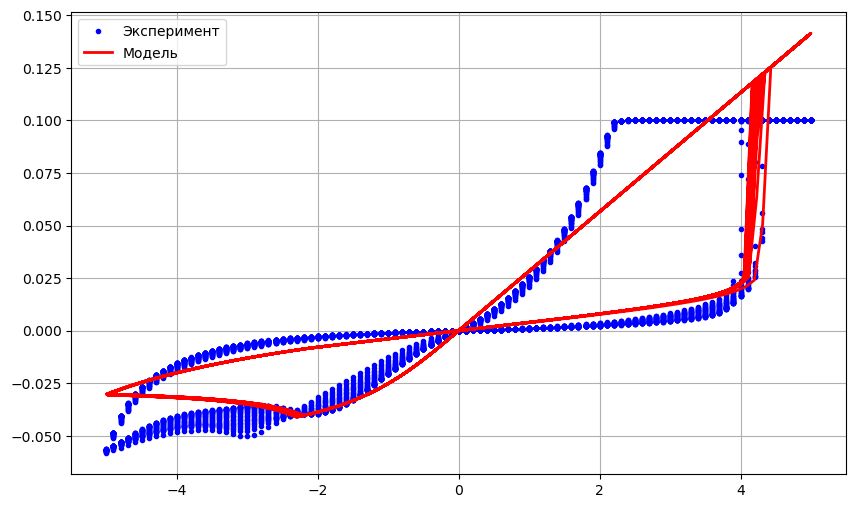

In [162]:
plt.figure(figsize=(10,6))
plt.plot(df_exp['v'], df_exp['c'], 'bo', ms=3, label='Эксперимент')
plt.plot(model.V_grid, model.get_I_solution(), 'r-', lw=2, label='Модель')
plt.legend()
plt.grid()
plt.show()


### Частичная оптимизация 

In [165]:
param_names = ['Ron', 'Roff', 'mu_v', 'Vp', 'Vn', 'D', 'x0']

opt_idx = [2]     # Ron, Roff, x0

fixed_params = model.params.copy()

def assemble_params(opt_params):
    full = fixed_params.copy()
    for i, idx in enumerate(opt_idx):
        full[idx] = opt_params[i]
    return full

def objective_partial(opt_params):
    full_params = assemble_params(opt_params)
    return model.objective_function(full_params)

x0_partial = model.params[opt_idx]

bounds_partial = [
    bounds[i] for i in opt_idx
]

res_partial = minimize(
    objective_partial,
    x0=x0_partial,
    method='Nelder-Mead',
    bounds=bounds_partial,
    options={
        'maxiter': 100,
        'ftol': 1e-10
    }
)

print("\nПараметры после частичной оптимизации:")
print_params(res_partial.x)
print("Final error:", res_partial.fun)


Параметры после частичной оптимизации:
  Ron =      2910.03
Final error: 0.0001988975214254011



Параметры после частичной оптимизации:
  Ron =      35.3541
 Roff =      2060.28
 mu_v =      2910.03
   Vp =     0.174543
   Vn =     -2.19477
    D =       529.95
   x0 =      0.88529
Final error: 0.0001988975214254011


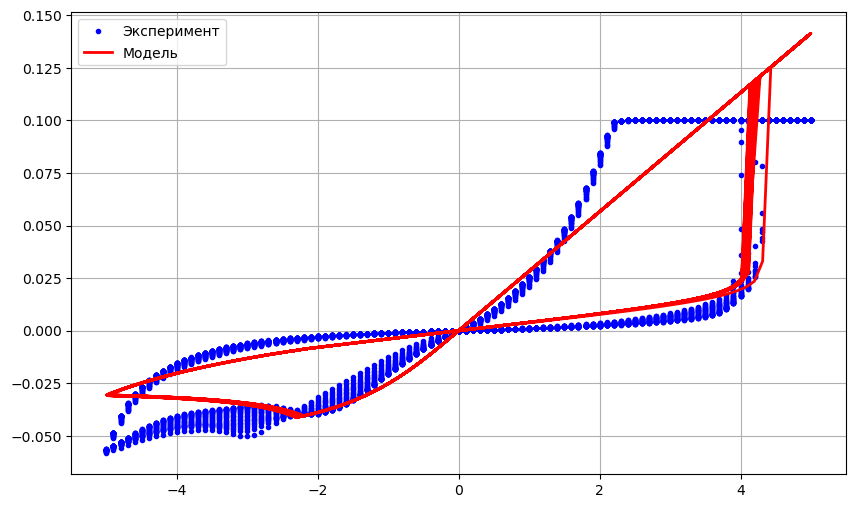

In [166]:
model.params = assemble_params(res_partial.x)

print("\nПараметры после частичной оптимизации:")
print_params(model.params)
print("Final error:", res_partial.fun)

plt.figure(figsize=(10,6))
plt.plot(df_exp['v'], df_exp['c'], 'bo', ms=3, label='Эксперимент')
plt.plot(model.V_grid, model.get_I_solution(), 'r-', lw=2, label='Модель')
plt.legend()
plt.grid()
plt.show()


In [167]:
params_identified = np.array([
    35.3541,    # Ron
    2060.28,    # Roff
    2910.03,    # mu_v
    0.174543,   # Vp
    -2.19477,   # Vn
    529.95,     # D
    0.88529    # x0
])

model = MemristorModel(df_exp, steps=5000)
model.params = params_identified.copy()